# Neural networks for algorithmic trading. 
# Part 1. Simple time series forecasting


In [2]:
%matplotlib inline
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D

In [3]:
def load_snp_returns():
    f = open('csv_data/table.csv', 'r').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            open_price = float(line.split(',')[1])
            close_price = float(line.split(',')[4])
            raw_data.append(close_price - open_price)
            raw_dates.append(line.split(',')[0])
        except:
            continue

    return raw_data[::-1], raw_dates[::-1]

In [4]:
raw_returns, raw_dates = load_snp_returns()
print(len(raw_returns), len(raw_dates))
print(raw_returns)

16705 16705
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [7]:
def load_snp_close():
    f = open('csv_data/table.csv', 'r').readlines()[1:]
    raw_data = []
    raw_dates = []
    for line in f:
        try:
            close_price = float(line.split(',')[4])
            raw_data.append(close_price)
            raw_dates.append(line.split(',')[0])
        except:
            continue

    return raw_data, raw_dates

In [8]:
raw_close, raw_close_dates = load_snp_close()
print(len(raw_close), len(raw_close_dates))

16705 16705


In [9]:
def split_into_chunks(data, train, predict, step, binary=True, scale=True):
    X, Y = [], []
    for i in range(0, len(data), step):
        try:
            x_i = data[i:i+train]
            y_i = data[i+train+predict]
            
            # Use it only for daily return time series
            if binary:
                if y_i > 0.:
                    y_i = [1., 0.]
                else:
                    y_i = [0., 1.]

                if scale: x_i = preprocessing.scale(x_i)
                
            else:
                timeseries = np.array(data[i:i+train+predict])
                if scale: timeseries = preprocessing.scale(timeseries)
                x_i = timeseries[:-1]
                y_i = timeseries[-1]
            
        except:
            break

        X.append(x_i)
        Y.append(y_i)

    return X, Y

In [10]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [11]:
def create_Xt_Yt(X, y, percentage=0.8):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test

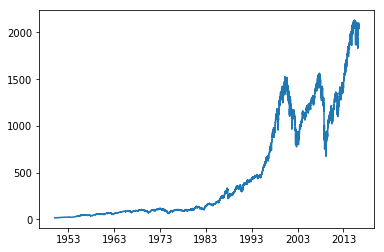

In [12]:
timeseries, dates = load_snp_close()
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

In [13]:
TRAIN_SIZE = 20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Xp, Yp = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=False, scale=False)
Xp, Yp = np.array(Xp), np.array(Yp)
X_trainp, X_testp, Y_trainp, Y_testp = create_Xt_Yt(Xp, Yp, percentage=0.9)

In [45]:
print(X==Xp)
print(Y==Yp)

[[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]]
[ True  True  True ...,  True  True  True]


In [14]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

model = Sequential()
model.add(Dense(500, input_shape = (TRAIN_SIZE, )))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('relu'))
model.compile(optimizer='adam', 
              loss='mse')

model.fit(X_train, 
          Y_train, 
          epochs=10, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)
score = model.evaluate(X_test, Y_test, batch_size=128)
print("\n\nScore = ",score)

Train on 13513 samples, validate on 1502 samples
Epoch 1/10
13513/13513 [==============================] - 1s - loss: 15441.6832 - val_loss: 6579.9879
Epoch 2/10
13513/13513 [==============================] - 1s - loss: 1670.5059 - val_loss: 13370.0212
Epoch 3/10
13513/13513 [==============================] - 1s - loss: 1337.6286 - val_loss: 10922.6402
Epoch 4/10
13513/13513 [==============================] - 0s - loss: 1154.6086 - val_loss: 7458.1345
Epoch 5/10
13513/13513 [==============================] - 1s - loss: 1135.6322 - val_loss: 11503.5339
Epoch 6/10
13513/13513 [==============================] - 1s - loss: 1003.7068 - val_loss: 14190.3219
Epoch 7/10
13513/13513 [==============================] - 0s - loss: 950.1259 - val_loss: 17805.4799
Epoch 8/10
13513/13513 [==============================] - 0s - loss: 928.7657 - val_loss: 17081.9313
Epoch 9/10
13513/13513 [==============================] - 0s - loss: 974.3305 - val_loss: 17301.6394
Epoch 10/10
 128/1669 [=>............

359.479


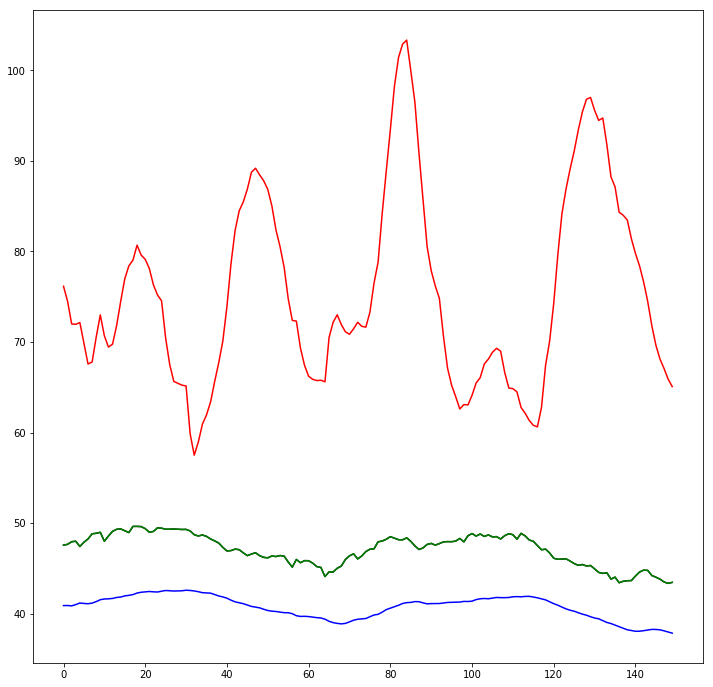

In [47]:
params = []
for xt in X_testp:
    xt = np.array(xt)
    mean_ = xt.mean()
    scale_ = xt.std()
    params.append([mean_, scale_])

predicted = model.predict(X_test)
new_predicted = []

for pred, par in zip(predicted, params):
    a = pred*par[1]
    a += par[0]
    new_predicted.append(a)
    

mse = mean_squared_error(predicted, new_predicted)
print(mse)

try:
    fig = plt.figure(figsize=(12, 12))
    plt.plot(Y_test[:150], color='black') # BLUE - trained RESULT
    plt.plot(predicted[:150], color='blue') # RED - trained PREDICTION
    plt.plot(Y_testp[:150], color='green') # GREEN - actual RESULT
    plt.plot(new_predicted[:150], color='red') # ORANGE - restored PREDICTION
    plt.show()
except Exception as e:
    print(str(e))

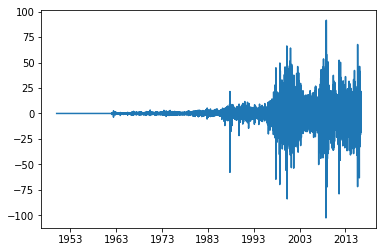

In [15]:
timeseries, dates = load_snp_returns()
dates = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
plt.plot(dates, timeseries)

In [16]:
TRAIN_SIZE = 20
TARGET_TIME = 1
LAG_SIZE = 1
EMB_SIZE = 1

X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True, scale=True)

print(len(X), len(Y))

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)
print(len(X_test), len(X_train))

16684 16684
1669 15015


In [66]:
HIDDEN_RNN = 10
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

model = Sequential()

# model.add(LSTM(input_shape = (EMB_SIZE,), input_dim=EMB_SIZE, output_dim=HIDDEN_RNN, return_sequences=True))
# model.add(LSTM(input_shape = (EMB_SIZE,), input_dim=EMB_SIZE, output_dim=HIDDEN_RNN, return_sequences=False))
model.add(LSTM(input_shape = (EMB_SIZE,), input_dim=EMB_SIZE, output_dim=HIDDEN_RNN, return_sequences=True))
model.add(LSTM(input_shape = (EMB_SIZE,), input_dim=EMB_SIZE, output_dim=HIDDEN_RNN, return_sequences=False))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(optimizer='adam', 
              loss='mse',
              metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=10, input_shape=(None, 1))`
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=False, units=10, input_shape=(None, 1))`


In [17]:
model.fit(X_train, 
          Y_train, 
          nb_epoch=20, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.1)


score = model.evaluate(X_test, Y_test, batch_size=128)
print("\n\nScore = ",score)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


ValueError: Error when checking target: expected activation_3 to have shape (None, 1) but got array with shape (15015, 2)

In [68]:
print(Y_test)
y_pred = model.predict(X_test)

[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]]


In [70]:
y_cls = np.argmax(Y_test, axis = 1)
y_cls_pred = np.argmax(y_pred, axis = 1)
print(y_cls == y_cls_pred)
print("Accuracy is : {0:>6.2}".format(1.*(y_cls==y_cls_pred).sum()/len(y_cls)))

[ True  True  True ..., False  True False]
Accuracy is :   0.54


In [27]:
timeseries, dates = load_snp_returns()
X, Y = split_into_chunks(timeseries, TRAIN_SIZE, TARGET_TIME, LAG_SIZE, binary=True)
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, percentage=0.9)

Y_train, Y_test = np.array([y.argmax() for y in Y_train]), np.array([y.argmax() for y in Y_test])


from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics, svm
from sklearn import linear_model

print('Training...')

#classifier = RandomForestClassifier(n_estimators = 100,
#                               n_jobs=4,
#                               verbose=1)

#classifier = linear_model.LogisticRegression(C=1e-5)

classifier = svm.SVC()
classifier.fit(X_train, Y_train)

print('Prediction...')
predicted = classifier.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(Y_test, predicted)))

Training...
Prediction...
Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.54      0.65      0.59       913
          1       0.43      0.32      0.37       756

avg / total       0.49      0.50      0.49      1669


